In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from ema_workbench import Samplers

from dike_model_function import DikeNetwork  # @UnresolvedImport

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

import pickle

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO);

In [4]:
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [5]:
planning_steps

array([0, 1, 2])

In [6]:
uncertainties = dike_model.uncertainties
outcomes = dike_model.outcomes
levers = dike_model.levers

problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [7]:
#for unc in dike_model.uncertainties:
#    print(repr(unc))

In [8]:
#for out in dike_model.outcomes:
#    print(repr(out))

In [9]:
for lev in dike_model.levers:
    print(repr(lev.name))

'0_RfR 0'
'0_RfR 1'
'0_RfR 2'
'1_RfR 0'
'1_RfR 1'
'1_RfR 2'
'2_RfR 0'
'2_RfR 1'
'2_RfR 2'
'3_RfR 0'
'3_RfR 1'
'3_RfR 2'
'4_RfR 0'
'4_RfR 1'
'4_RfR 2'
'EWS_DaysToThreat'
'A.1_DikeIncrease 0'
'A.1_DikeIncrease 1'
'A.1_DikeIncrease 2'
'A.2_DikeIncrease 0'
'A.2_DikeIncrease 1'
'A.2_DikeIncrease 2'
'A.3_DikeIncrease 0'
'A.3_DikeIncrease 1'
'A.3_DikeIncrease 2'
'A.4_DikeIncrease 0'
'A.4_DikeIncrease 1'
'A.4_DikeIncrease 2'
'A.5_DikeIncrease 0'
'A.5_DikeIncrease 1'
'A.5_DikeIncrease 2'


In [10]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [11]:
pol = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 0,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

In [12]:
pol

Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0})

In [13]:
policies = pol
n_exp = 500

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_exp, policies = pol, uncertainty_sampling=Samplers.SOBOL)
        
experiments_sobol, outcomes_sobol = results

[MainProcess/INFO] pool started with 4 workers
/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 20000 scenarios * 1 policies * 1 model(s) = 20000 experiments
  0%|                                     | 1/20000 [00:02<15:54:09,  2.86s/it]Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 253, 

In [14]:
outcomes_sobol['Expected Number of Deaths'] = np.nan_to_num(outcomes_sobol['Expected Number of Deaths'], nan = 3.01437703)

In [41]:
deaths_sobol = sobol.analyze(problem, outcomes_sobol['Expected Number of Deaths'],calc_second_order=True, print_to_console=True)
damages_sobol = sobol.analyze(problem, outcomes_sobol['Expected Annual Damage'],calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.013868  0.011030
A.1_Bmax                 0.031482  0.015077
A.1_Brate                0.005820  0.010653
A.1_pfail                0.286254  0.044262
A.2_Bmax                 0.006478  0.010629
A.2_Brate                0.005420  0.010650
A.2_pfail                0.028745  0.013736
A.3_Bmax                 0.005440  0.010657
A.3_Brate                0.005412  0.010652
A.3_pfail                0.773028  0.087776
A.4_Bmax                 0.005422  0.010648
A.4_Brate                0.005413  0.010652
A.4_pfail                0.006591  0.010902
A.5_Bmax                 0.005412  0.010652
A.5_Brate                0.005412  0.010652
A.5_pfail                0.019297  0.011498
discount rate 0          0.005412  0.010652
discount rate 1          0.005412  0.010652
discount rate 2          0.005412  0.010652
                               S1   S1_conf
A.0_ID flood wave shape  0.003343  0.014330
A.1_Bmax                 0.00503

In [57]:
Si_filter = {k:deaths_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_deaths = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_deaths['ST-S1'] = Si_df_deaths['ST'] - Si_df_deaths['S1']
Si_df_deaths

,ST,ST_conf,S1,S1_conf,ST-S1
A.0_ID flood wave shape,0.013868,0.011030,0.003343,0.014330,0.010525
A.1_Bmax,0.031482,0.015077,0.005034,0.020350,0.026448
A.1_Brate,0.005820,0.010653,0.003200,0.009660,0.002620
A.1_pfail,0.286254,0.044262,0.169728,0.068125,0.116527
A.2_Bmax,0.006478,0.010629,0.006092,0.010340,0.000385
A.2_Brate,0.005420,0.010650,0.004637,0.009380,0.000783
A.2_pfail,0.028745,0.013736,0.006680,0.020533,0.022065
A.3_Bmax,0.005440,0.010657,0.004448,0.009239,0.000992
A.3_Brate,0.005412,0.010652,0.004731,0.009338,0.000682
A.3_pfail,0.773028,0.087776,0.656297,0.105095,0.116730


In [ ]:
# A.1_pfail and A.3_pfail seem to have higher order interactions

In [55]:
## However, the S2 dataframe shows these interactions are not very strong
#S2_deaths_sobol= pd.DataFrame(deaths_sobol['S2'])
#S2_deaths_sobol

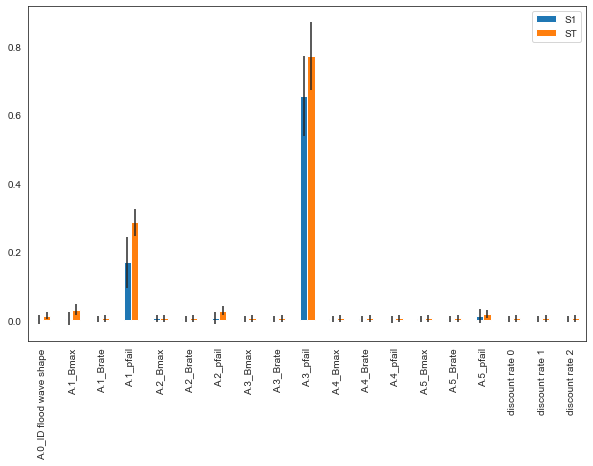

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [45]:
Si_filter = {k:damages_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_damages = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_damages['ST-S1'] = Si_df_damages['ST'] - Si_df_damages['S1']
Si_df_damages

,ST,ST_conf,S1,S1_conf,ST-S1
A.0_ID flood wave shape,0.004858,0.001355,-0.003440,0.009526,0.008298
A.1_Bmax,0.009786,0.005113,0.003198,0.011818,0.006589
A.1_Brate,0.000151,0.000190,-0.001028,0.001366,0.001179
A.1_pfail,0.717187,0.085998,0.662021,0.085315,0.055166
A.2_Bmax,0.000418,0.000360,0.000864,0.002317,-0.000445
A.2_Brate,0.000009,0.000007,-0.000034,0.000268,0.000043
A.2_pfail,0.023173,0.005744,0.017003,0.016155,0.006170
A.3_Bmax,0.000039,0.000022,-0.000192,0.000717,0.000231
A.3_Brate,0.000001,0.000001,0.000004,0.000166,-0.000003
A.3_pfail,0.230701,0.038294,0.191060,0.053554,0.039641


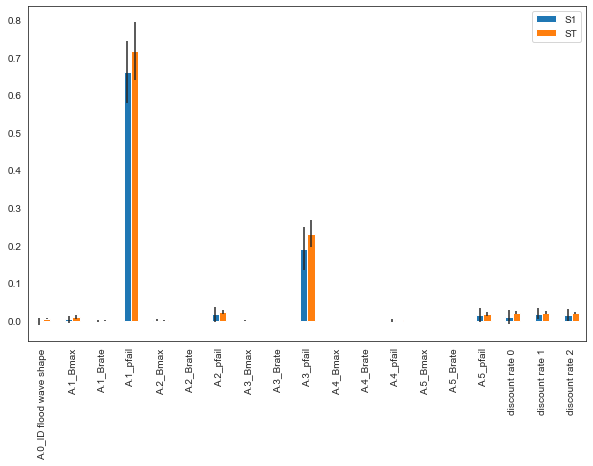

In [19]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [49]:
S2_deaths_sobol= pd.DataFrame(deaths_sobol['S2'])